In [1]:
import pickle
import warnings
import sys
from IPython.display import Image, HTML

import pandas as pd
import numpy as np
from scipy.stats import norm, uniform
import pymc3 as pm
from theano import shared

import seaborn as sb
import matplotlib.pyplot as pl
from matplotlib import rcParams
from matplotlib import ticker as mtick
import cmocean.cm as cmo
import arviz as ar

rcParams['axes.formatter.limits'] = (-2, 3)
rcParams['axes.titlesize'] = 18
rcParams['axes.labelsize'] = 16
rcParams['font.size'] = 16
rcParams['ytick.labelsize'] = 16
rcParams['xtick.labelsize'] = 16
rcParams['legend.fontsize'] = 16
rcParams['xtick.minor.visible'] = True

In [2]:
print('Versions:')
print('---------')
print(f'python:  {sys.version.split("|")[0]}')
print(f'numpy:   {np.__version__}')
print(f'pandas:  {pd.__version__}')
print(f'seaborn: {sb.__version__}')
print(f'pymc3:   {pm.__version__}')
print(f'arviz:   {ar.__version__}')

Versions:
---------
python:  3.6.8 
numpy:   1.15.4
pandas:  0.24.1
seaborn: 0.9.0
pymc3:   3.6
arviz:   0.3.2


In [3]:
%matplotlib inline
warnings.filterwarnings('ignore',  category=FutureWarning)

In [4]:
def make_lower_triangle(gs):
    for i, j in zip(*np.triu_indices_from(gs.axes, 1)):
        gs.axes[i, j].set_visible(False)
    gs.axes[0,0].set_xlabel(gs.axes[0,0].get_ylabel())
    gs.axes[0,0].set_ylabel('')
    gs.axes[0,0].set_yticks([])

## <center><u>Statistical Modeling for the Busy Scientist/Engineer</u></center>






https://github.com/madHatter106/chlorophyll_models/blob/master/Bayesian%20Tutorial.ipynb

<a id='TOP'></a>

## Notebook Contents
0. [Motivation](#MOTIV)
1. [Basics: Joint probability, Inverse probability and Bayes' Theorem](#BASIC)
2. [Inferring Chl](#JustCHL)
    1. [Grid Approximation](#GRID)
        1. [Impact of priors](#PriorImpact)
        2. [Impact of data set size](#DataImpact)
    2. [MCMC](#MCMC)
    3. [PyMC3](#PyMC3)
3. [Regression](#Reg)
    1. [Data Preparation](#DataPrep)
    2. [Regression in PyMC3](#RegPyMC3)
    3. [Checking Priors](#PriorCheck)
    4. [Model Fitting](#Mining)
    5. [Flavors of Uncertainty](#UNC)
4. [Conclusion](#Conclusion)
5. [To be Continued...](#Next)

<a id='MOTIV'></a>

### Mentioned in Jamborfuffle 1:
* DATA ISSUES
* MODELING ISSUES

* DATA
    1. noisy data invites abuse:
        * over-emphasis on fitting data at hand
        * arbitrary outlier definition and removal
        * data hacking to improve model fit
    2. small datasets for global models
        * high overfitting risk
        * global/regional debate

* MODELS
    1. opaque
        * implicit, unclear assumptions
        * hard to understand, parameterization impossible to replicate
    2. ad-hoc uncertainty generation based on unverified assumptions
    3. lack of contextual information
    4. lack of clear method for comparing/selecting models

## Modeling Objectives
* Transparent, sensible, intepretable, criticizable models
    * explicit assumptions
    * model construction based on causal reasoning
    * emphasis on process generating observations rather than data at hand
* Persistent performance (reduced overfitting, easy to diagnose, easy to train)
* Easily computable uncertainty
* Data efficiency

### Mentioned in Jamborfuffle 1:
* DATA ISSUES
* MODELING ISSUES

$\rightarrow$ Hierarchical Bayes $\in$ Probabilistic Modeling

#### <u><font color='purple'>Tutorial Overview:</font></u>
* Probabilistic modeling for the beginner
    1. The basics<br>
    2. Under the hood: inferring chlorophyll
    3. Regression: adding a predictor to estimate chlorophyll

* <font color='blue'> Probabilistic modeling for the not-so-beginner
    1. Including data uncertainty & imputing missing data
    2. Empirical vs. semi-analytical: a useful dichotomy?
    3. Causal inference and the backdoor criterion
    4. Model comparison/selection using Information Theory
    5. Hierarchical (multi-level) models:
        * Pooled, unpooled and partially pooled models
        * Regionally aware global models
</font>

#### <u><font color='purple'>Tutorial Overview:</font></u>
* Probabilistic modeling for the beginner<br>
    <font color='red'>$\rightarrow$The basics</font><br>
    $\rightarrow$Under the hood: inferring chlorophyll<br>
    $\rightarrow$Regression: adding a predictor to estimate chlorophyll

<a id='BASIC'></a>
[Back to Contents](#TOP)

### A teensy bit of probability:

* Joint probability of two events $A$, $B$:
$$P(A, B)=P(A|B)\times P(B)=P(B|A)\times P(A)$$

* A, B independent: $$P(A|B) = P(A)\ \leftrightarrow P(A,B) = P(A)\times P(B)$$

* Inverse probability:$$\boxed{P(A|B) = \frac{P(B|A) \times P(A)}{P(B)}}$$ 

$\rightarrow$usually referred to as Bayes' theorem

### $\Rightarrow$Extending Bayes' theorem to model building

Given a model:
* Hypotheses ($H$): values that model parameters can take
* Data ($D$)

Approach 
* formulate initial opinion on what $H$ might include and with what probability, $P(H)$
* collect data ($D$) 
* update $P(H)$ using $D$ and Bayes' theorem

$$\frac{P(H)\times P(D|H)}{P(D)} = P(H|D)$$

Getting rid of the evidence, P(D)...
$$ P(H) \times P(D|H) \propto P(H|D)$$

#### The prior
$$\underline{P(H)}\times P(D|H) \propto P(H|D)$$

* $H$: set of values that model parameters might take with corresponding probability
* h=x & p(h=x)
* use a probability distribution to express $P(H)$

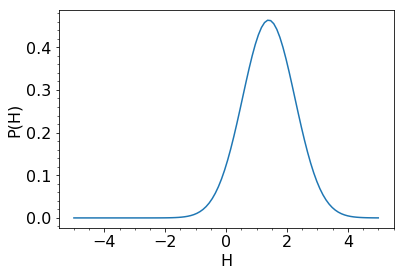

In [5]:
# build 1D grid of possible values
h = np.linspace(-5, 5, num=100)
μ_prior = 1.4 
σ_prior = 0.86
# compute probability at each a h
p_h = norm.pdf(h, loc=μ_prior, scale=σ_prior) 
pl.plot(h, p_h); pl.ylabel('P(H)'); pl.xlabel('H');

#### The likelihood

$$P(H)\times \underline{P(D|H)} \propto  P(H|D)$$


* probability of the data, $D$, *given* $H$
* classically maximized$\rightarrow$best fit $\rightarrow$NOT DONE HERE!
* data may misrepresent the big picture

#### The posterior:

$$P(H)\times P(D|H) \propto \underline{P(H|D)}$$


* it's what we're after!!!
* updated probability of $H$ after collecting $D$
* used as prior for next iteration $P(H|D)\rightarrow P(H)$
* $P(H|D)$ naturally yields uncertainty

#### <u><font color='purple'>Tutorial Overview:</font></u>
* Probabilistic modeling for the beginner<br>
    $\rightarrow$~~The basics~~<br>
    <font color='red'>$\rightarrow$Under the hood: inferring chlorophyll</font><br>
    $\rightarrow$Regression: adding a predictor to estimate chlorophyll

<a id='JustCHL'></a>
[Back to Contents](#TOP)

## Under the hood: Inferring chlorophyll
* <font color='red'>Grid approximation: computing probability for all parameter values</font>
* Magical MCMC: how it works
* Probabilistic Programming with PyMC3: industrial grade MCMC

[Back to Contents](#TOP)
<a id='GRID'></a>

### Grid approximation: computing probability for all parameter values<br>

$\ \ \ \rightarrow$mechanistically straightforward<br>
$\ \ \ \rightarrow$computationally expensive!

In [5]:
df_data = pd.read_pickle('./pickleJar/df_logMxBlues.pkl')

In [6]:
df_data[['MxBl-Gr', 'chl_l']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4459 entries, 0 to 4458
Data columns (total 2 columns):
MxBl-Gr    4453 non-null float64
chl_l      4127 non-null float64
dtypes: float64(2)
memory usage: 104.5 KB


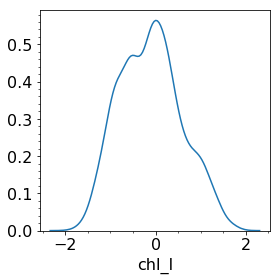

In [7]:
f, ax = pl.subplots(figsize=(4,4))
sb.kdeplot(df_data.chl_l, ax=ax, legend=False);
ax.set_xlabel('chl_l');
f.tight_layout()
f.savefig('./figJar/Presentation/fig1_chl.svg', dpi=300, format='svg')

### Grid approximation:

* Define a model to approximate the process that generates the observations
* Build the grid of model parameters
* Propose priors
* Compute likelihood
* Compute posterior

### Grid approximation:

* Define a model to approximate the process that generates the observations
    * Theory observation generation well approximated by a Gaussian
    * Hypotheses include 2 vectors; mean $\mu$ and standard deviation $\sigma$
* Build the grid of model parameters
    * 2D grid of $(\mu, \sigma)$ pair
* Propose priors
    * define priors for both $\mu$ and $\sigma$
* Compute likelihood
* Compute posterior

Define grid with axes $\mu$ (mean) and $\sigma$ (std. dev.)<br>
$\rightarrow$target data is $log_{10}(chl)$

In [8]:
μ = np.linspace(-2, 2, num=200) # μ-axi
σ = np.linspace(0, 2, num=200) # σ-axis

In [9]:
df_grid = pd.DataFrame([[μ_i, σ_i]
                        for σ_i in σ for μ_i in μ], columns=['μ', 'σ'])

In [10]:
print(df_grid.shape)
df_grid.head(7)

(40000, 2)


,μ,σ
0,-2.000000,0.0
1,-1.979899,0.0
2,-1.959799,0.0
3,-1.939698,0.0
4,-1.919598,0.0
5,-1.899497,0.0
6,-1.879397,0.0


#### Define prior probability distributions for $\mu$ and $\sigma$ 
* $\mu \sim \mathcal{N}(1, 1)$: a gaussian distribution centered at 1, with an sd of 1
* $\sigma \sim \mathcal{U}(0, 2)$: a uniform distribution between 0 and 2

In [11]:
μ_prior = norm.logpdf(df_grid.μ, 1, 1)
σ_prior = uniform.logpdf(df_grid.σ, 0, 2)

<img src="./figJar/Presentation/tutorial_1_2.png">

#### Compute multi-dimensional prior probability

In [12]:
# log prior probability
df_grid['log_prior_prob'] = μ_prior + σ_prior
# straight prior probability
df_grid['prior_prob'] = np.exp(df_grid.log_prior_prob
                                - df_grid.log_prior_prob.max())

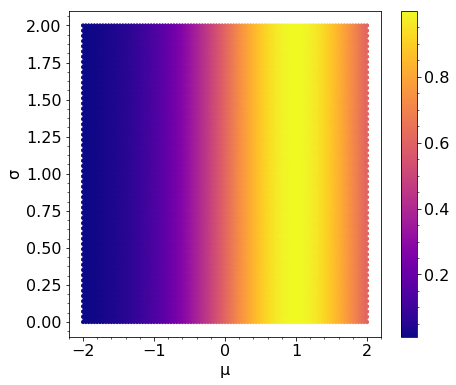

In [13]:
df_grid.plot.hexbin(x='μ', y='σ', C='prior_prob', figsize=(7,6),
                     cmap='plasma', sharex=False);

#### Bringing in the data...

<center><img src='./figJar/Presentation/fig1_chl.svg', width=400px, height=400px></center>

$\Rightarrow$Subsample the data<br>
$\ \ \ \rightarrow$computationally more tractable for grid approximation<br>
$\ \ \ \rightarrow$show the impact of prior choice

In [14]:
sample_N = 10
df_data_s = df_data.dropna().sample(n=sample_N)

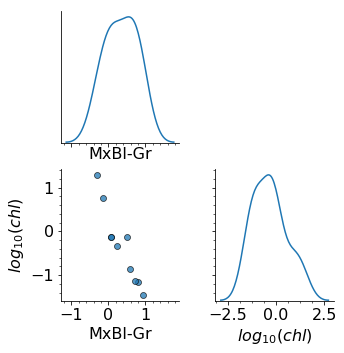

In [15]:
g = sb.PairGrid(df_data_s.loc[:,['MxBl-Gr', 'chl_l']],
                diag_sharey=False)
g.map_diag(sb.kdeplot, )
g.map_offdiag(sb.scatterplot, alpha=0.75, edgecolor='k');
make_lower_triangle(g)
g.axes[1,0].set_ylabel(r'$log_{10}(chl)$');
g.axes[1,1].set_xlabel(r'$log_{10}(chl)$');

#### Compute Log-Likelihood of the data given every  pair $(\mu,\sigma)$ 

In [16]:
df_grid['LL'] = np.sum(norm.logpdf(df_data_s.chl_l.values.reshape(1, -1),
                                    loc=df_grid.μ.values.reshape(-1, 1),
                                    scale=df_grid.σ.values.reshape(-1, 1)
                                   ), axis=1)

#### Compute Posterior $P(\mu,\sigma\ | data) \propto P(data | \mu, \sigma) \times P(\mu, \sigma)$

In [17]:
# compute log-probability
df_grid['log_post_prob'] = df_grid.LL + df_grid.log_prior_prob
# convert to straight prob.
df_grid['post_prob'] = np.exp(df_grid.log_post_prob
                               - df_grid.log_post_prob.max())

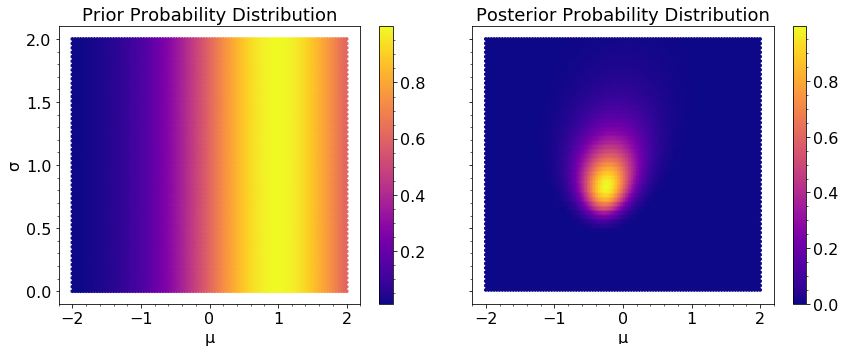

In [19]:
# Plot Multi-Dimensional Prior and Posterior
f, ax = pl.subplots(ncols=2, figsize=(12, 5), sharey=True)
df_grid.plot.hexbin(x='μ', y='σ', C='prior_prob',
                    cmap='plasma', sharex=False, ax=ax[0])
df_grid.plot.hexbin(x='μ', y='σ', C='post_prob',
                     cmap='plasma', sharex=False, ax=ax[1]);
ax[0].set_title('Prior Probability Distribution')
ax[1].set_title('Posterior Probability Distribution')
f.tight_layout()
f.savefig('./figJar/Presentation/grid1.svg')

<img src="figJar/Presentation/grid1.svg"/>

In [82]:
# Compute Marginal Priors and Posteriors for each Parameter
df_μ = df_grid.groupby(['μ']).sum().drop('σ', axis=1)[['prior_prob',
                                                        'post_prob']
                                                      ].reset_index()
df_σ = df_grid.groupby(['σ']).sum().drop('μ', axis=1)[['prior_prob',
                                                        'post_prob']
                                                      ].reset_index() 

# Normalize Probability Distributions
df_μ.prior_prob /= df_μ.prior_prob.max()
df_μ.post_prob /= df_μ.post_prob.max()
df_σ.prior_prob /= df_σ.prior_prob.max()
df_σ.post_prob /= df_σ.post_prob.max()

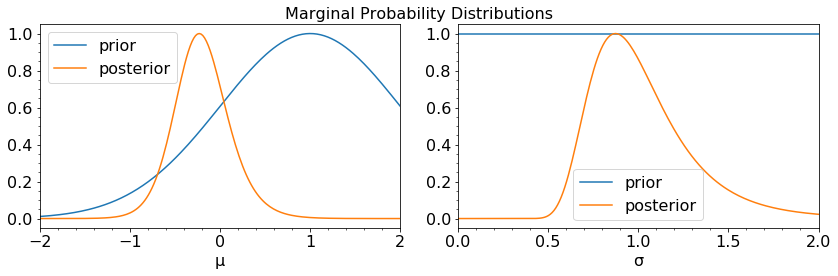

In [86]:
#Plot Marginal Priors and Posteriors
f, ax = pl.subplots(ncols=2, figsize=(12, 4))
df_μ.plot(x='μ', y='prior_prob', ax=ax[0], label='prior');
df_μ.plot(x='μ', y='post_prob', ax=ax[0], label='posterior')
df_σ.plot(x='σ', y='prior_prob', ax=ax[1], label='prior')
df_σ.plot(x='σ', y='post_prob', ax=ax[1], label='posterior');
f.suptitle('Marginal Probability Distributions', fontsize=16);
f.tight_layout(pad=2)
f.savefig('./figJar/Presentation/grid2.svg')

<img src="./figJar/Presentation/grid2.svg?modified=2"/>

[Back to Contents](#TOP)
<a id='PriorImpact'></a>

### Impact of Priors

In [73]:
def compute_bayes_framework(data, priors_dict):
    # build grid:
    μ = np.linspace(-2, 2, num=200)
    σ = np.linspace(0, 2, num=200)
    df_b = pd.DataFrame([[μ_i, σ_i] for σ_i in σ for μ_i in μ],
                        columns=['μ', 'σ'])
    # compute/store distributions
    μ_prior = norm.logpdf(df_b.μ, priors_dict['μ_mean'],
                          priors_dict['μ_sd'])
    σ_prior = uniform.logpdf(df_b.σ, priors_dict['σ_lo'],
                             priors_dict['σ_hi'])
    # compute joint prior
    df_b['log_prior_prob'] = μ_prior + σ_prior 
    df_b['prior_prob'] = np.exp(df_b.log_prior_prob
                                    - df_b.log_prior_prob.max())
    # compute log likelihood
    df_b['LL'] = np.sum(norm.logpdf(data.chl_l.values.reshape(1, -1),
                                    loc=df_b.μ.values.reshape(-1, 1),
                                    scale=df_b.σ.values.reshape(-1, 1)
                                   ), axis=1)
    # compute joint posterior
    df_b['log_post_prob'] = df_b.LL + df_b.log_prior_prob
    df_b['post_prob'] = np.exp(df_b.log_post_prob
                               - df_b.log_post_prob.max())
    return df_b


def plot_posterior(df_, ax1, ax2):
    df_.plot.hexbin(x='μ', y='σ', C='prior_prob',
                        cmap='plasma', sharex=False, ax=ax1)
    df_.plot.hexbin(x='μ', y='σ', C='post_prob',
                         cmap='plasma', sharex=False, ax=ax2);
    ax1.set_title('Prior Probability Distribution')
    ax2.set_title('Posterior Probability Distribution')
    
    
def plot_marginals(df_, ax1, ax2, plot_prior=True):
    """Compute marginal posterior distributions."""
    df_μ = df_.groupby(['μ']).sum().drop('σ',
                                         axis=1)[['prior_prob',
                                                  'post_prob']
                                                ].reset_index()
    df_σ = df_.groupby(['σ']).sum().drop('μ',
                                         axis=1)[['prior_prob',
                                                  'post_prob']
                                                ].reset_index() 
    
    # Normalize Probability Distributions
    df_μ.prior_prob /= df_μ.prior_prob.max()
    df_μ.post_prob /= df_μ.post_prob.max()
    df_σ.prior_prob /= df_σ.prior_prob.max()
    df_σ.post_prob /= df_σ.post_prob.max()

    #Plot Marginal Priors and Posteriors
    if plot_prior:
        df_μ.plot(x='μ', y='prior_prob', ax=ax1, label='prior');
        df_σ.plot(x='σ', y='prior_prob', ax=ax2, label='prior')
    df_μ.plot(x='μ', y='post_prob', ax=ax1, label='posterior')
    df_σ.plot(x='σ', y='post_prob', ax=ax2, label='posterior');

Try two priors:
1. $\mu \sim \mathcal{N}(1, 1)$, $\sigma \sim \mathcal{U}(0, 2)$ - a weakly informative prior

In [88]:
weak_prior=dict(μ_mean=1, μ_sd=1, σ_lo=0, σ_hi=2)
df_grid_1 = compute_bayes_framework(df_data_s, priors_dict=weak_prior)

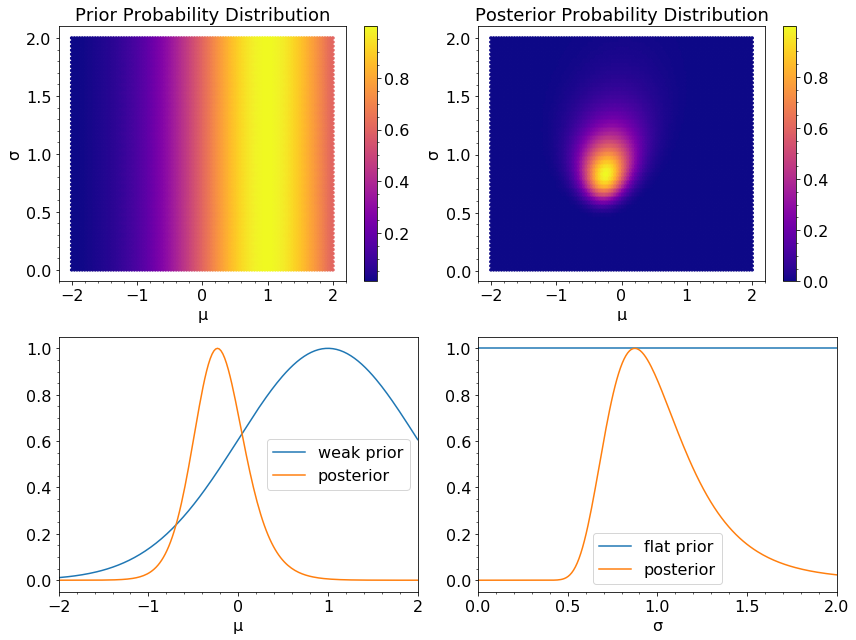

In [78]:
f , axp = pl.subplots(ncols=2, nrows=2, figsize=(12, 9))
axp = axp.ravel()
plot_posterior(df_grid_1, axp[0], axp[1])
plot_marginals(df_grid_1, axp[2], axp[3])
axp[2].legend(['weak prior', 'posterior'])
axp[3].legend(['flat prior', 'posterior'])
f.tight_layout()
f.savefig('./figJar/Presentation/grid3.svg')

<img src="./figJar/Presentation/grid3.svg?modified=3"/>

2. $\mu \sim \mathcal{N}(-1.5, 0.1)$, $\sigma \sim \mathcal{U}(0, 2)$ - a strongly informative prior

In [87]:
strong_prior=dict(μ_mean=-1.5, μ_sd=.1, σ_lo=0, σ_hi=2)
df_grid_2 = compute_bayes_framework(df_data_s, priors_dict=strong_prior)

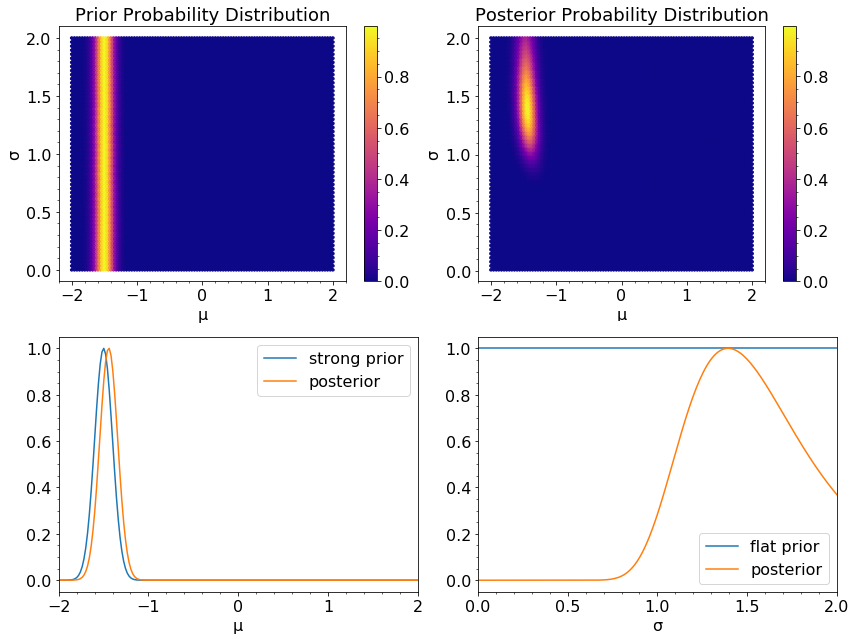

In [77]:
f , axp = pl.subplots(ncols=2, nrows=2, figsize=(12, 9))
axp = axp.ravel()
plot_posterior(df_grid_2, axp[0], axp[1])
plot_marginals(df_grid_2, axp[2], axp[3])
axp[2].legend(['strong prior', 'posterior'])
axp[3].legend(['flat prior', 'posterior'])
f.tight_layout()
f.savefig('./figJar/Presentation/grid4.svg')

<img src="./figJar/Presentation/grid4.svg?modified=1"/>

[Back to Contents](#TOP)
<a id='DataImpact'></a>

### Impact of data set size
* sub-sample size is now 500 samples,
* same two priors used

In [27]:
sample_N = 500

# compute the inference dataframe
df_data_s = df_data.dropna().sample(n=sample_N)

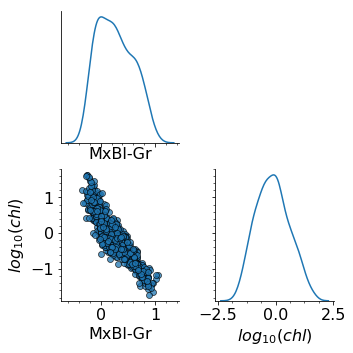

In [28]:
# display the new sub-sample
g = sb.PairGrid(df_data_s.loc[:,['MxBl-Gr', 'chl_l']],
                diag_sharey=False)
g.map_diag(sb.kdeplot, )
g.map_offdiag(sb.scatterplot, alpha=0.75, edgecolor='k');
make_lower_triangle(g)
g.axes[1,0].set_ylabel(r'$log_{10}(chl)$');
g.axes[1,1].set_xlabel(r'$log_{10}(chl)$');

In [89]:
%%time
df_grid_3 = compute_bayes_framework(df_data_s, priors_dict=weak_prior)

CPU times: user 1.21 s, sys: 771 ms, total: 1.99 s
Wall time: 1.83 s


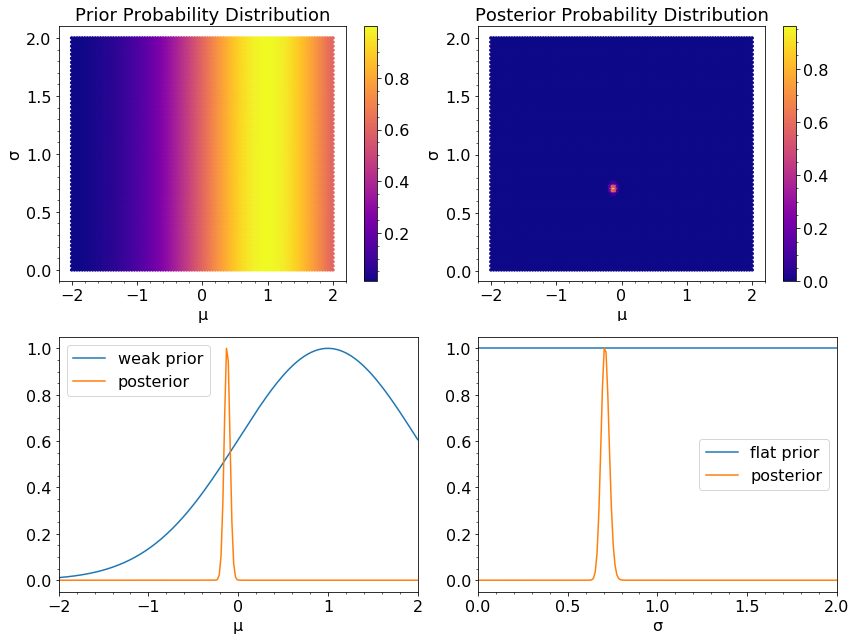

In [76]:
f , axp = pl.subplots(ncols=2, nrows=2, figsize=(12, 9))
axp = axp.ravel()
plot_posterior(df_grid_3, axp[0], axp[1])
plot_marginals(df_grid_3, axp[2], axp[3])
axp[2].legend(['weak prior', 'posterior'])
axp[3].legend(['flat prior', 'posterior'])
f.tight_layout()
f.savefig('./figJar/Presentation/grid5.svg')

<img src="./figJar/Presentation/grid5.svg?modified=4"/>

In [91]:
df_grid_4 = compute_bayes_framework(df_data_s, priors_dict=strong_prior)

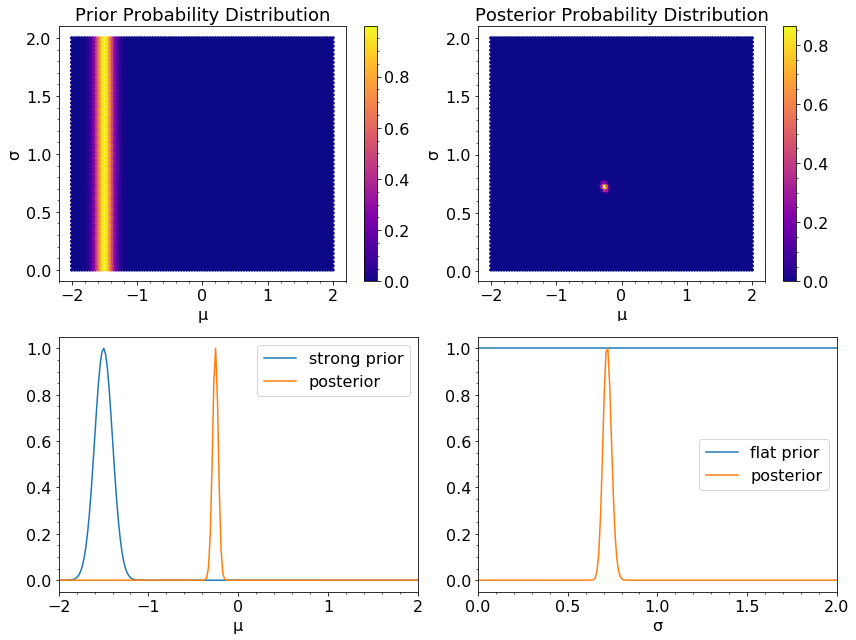

In [79]:
f , axp = pl.subplots(ncols=2, nrows=2, figsize=(12, 9))
axp = axp.ravel()
plot_posterior(df_grid_4, axp[0], axp[1])
plot_marginals(df_grid_4, axp[2], axp[3])
axp[2].legend(['strong prior', 'posterior'])
axp[3].legend(['flat prior', 'posterior'])
f.tight_layout()
f.savefig('./figJar/Presentation/grid6.svg')

<img src="./figJar/Presentation/grid6.svg?modified=8"/>

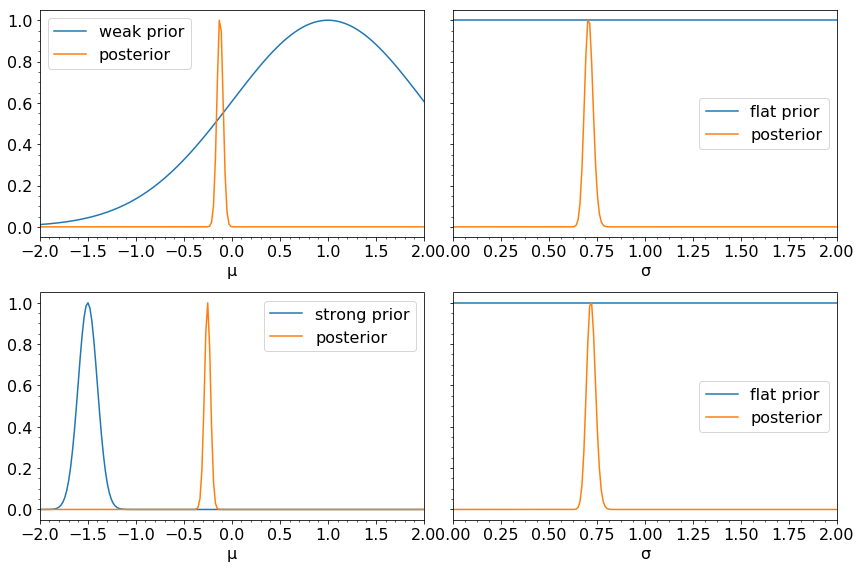

In [80]:
f , axp = pl.subplots(ncols=2, nrows=2, figsize=(12, 8), sharey=True)
axp = axp.ravel()
plot_marginals(df_grid_3, axp[0], axp[1])
plot_marginals(df_grid_4, axp[2], axp[3])
axp[0].legend(['weak prior', 'posterior'])
axp[1].legend(['flat prior', 'posterior'])
axp[2].legend(['strong prior', 'posterior'])
axp[3].legend(['flat prior', 'posterior'])
f.tight_layout()
f.savefig('./figJar/Presentation/grid7.svg')

<img src="./figJar/Presentation/grid7.svg?modified=4"/>

***And using all the data?***

In [35]:
%%time
priors=dict(μ_mean=-1.5, μ_sd=.1, σ_lo=0, σ_hi=2)
try:
    df_grid_all_data= compute_bayes_framework(df_data, priors_dict=priors)
except MemoryError:
    print("OUT OF MEMORY!")
    print("--------------")

OUT OF MEMORY!
--------------
CPU times: user 2.22 s, sys: 4.42 s, total: 6.64 s
Wall time: 21.9 s


## Under the hood: Inferring chlorophyll distribution

* ~~Grid approximation: computing probability everywhere~~
* <font color='red'>Magical MCMC: Dealing with computational complexity</font>
* Probabilistic Programming with PyMC3: Industrial grade MCMC

[Back to Contents](#TOP)
<a id="MCMC"></a>

### Magical MCMC: Dealing with computational complexity

* Grid approximation:
    * useful for understanding mechanics of Bayesian computation
    * computationally intensive
    * impractical and often intractable for large data sets or high-dimension models

    
* MCMC allows sampling <u>where it **probabilistically matters**</u>:
    * compute current probability given location in parameter space
    * propose jump to new location in parameter space
    * compute new probability at proposed location
    * jump to new location if $\frac{new\ probability}{current\ probability}>1$ 
    * jump to new location if $\frac{new\ probability}{current\ probability}>\gamma\in [0, 1]$
    * otherwise stay in current location

In [49]:
def mcmc(data, μ_0=0.5, n_samples=1000,):
    print(f'{data.size} data points')
    data = data.reshape(1, -1)
    # set priors
    σ=0.75 # keep σ fixed for simplicity
    trace_μ = np.nan * np.ones(n_samples) # trace: where the sampler has been
    trace_μ[0] = μ_0 # start with a first guess
    for i in range(1, n_samples):
        proposed_μ = norm.rvs(loc=trace_μ[i-1], scale=0.1, size=1)
        prop_par_dict = dict(μ=proposed_μ, σ=σ)
        curr_par_dict = dict(μ=trace_μ[i-1], σ=σ)
        log_prob_prop = get_log_lik(data, prop_par_dict
                                   ) + get_log_prior(prop_par_dict)
        log_prob_curr = get_log_lik(data, curr_par_dict
                                   ) + get_log_prior(curr_par_dict) 
        ratio = np.exp(log_prob_prop -  log_prob_curr)
        if ratio > 1:
            # accept proposal
            trace_μ[i] = proposed_μ
        else:
            # evaluate low proba proposal
            if uniform.rvs(size=1, loc=0, scale=1) > ratio:
                # reject proposal
                trace_μ[i] = trace_μ[i-1]    
            else:
                # accept proposal
                trace_μ[i] = proposed_μ
    return trace_μ

In [38]:
 def get_log_lik(data, param_dict):
    return np.sum(norm.logpdf(data, loc=param_dict['μ'],
                              scale=param_dict['σ']
                             ),
                  axis=1)

def get_log_prior(par_dict, loc=1, scale=1):
    return norm.logpdf(par_dict['μ'], loc=loc, scale=scale)

#### Timing MCMC

In [50]:
%%time
mcmc_n_samples = 2000
trace1 = mcmc(data=df_data_s.chl_l.values, n_samples=mcmc_n_samples)

500 data points
CPU times: user 1.08 s, sys: 7.31 ms, total: 1.08 s
Wall time: 1.09 s


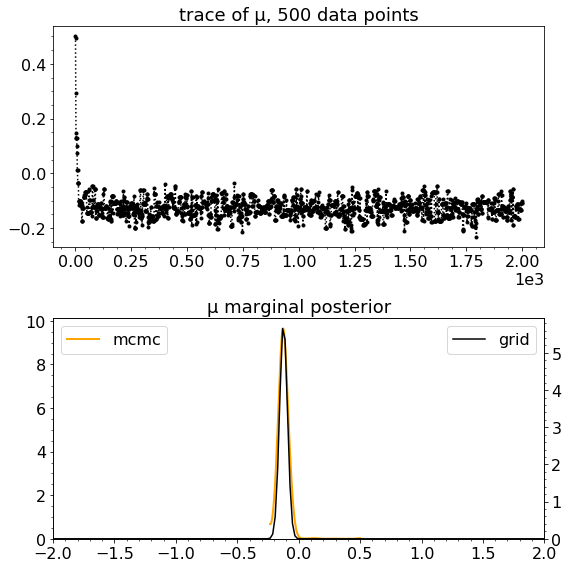

In [46]:
f, ax = pl.subplots(nrows=2, figsize=(8, 8))
ax[0].plot(np.arange(mcmc_n_samples), trace1, marker='.',
           ls=':', color='k')
ax[0].set_title('trace of μ, 500 data points')
ax[1].set_title('μ marginal posterior')
pm.plots.kdeplot(trace1, ax=ax[1], label='mcmc',
                 color='orange', lw=2, zorder=1)
ax[1].legend(loc='upper left')
ax[1].set_ylim(bottom=0)
df_μ = df_grid_3.groupby(['μ']).sum().drop('σ',
                                     axis=1)[['post_prob']
                                            ].reset_index()
ax2 = ax[1].twinx()
df_μ.plot(x='μ', y='post_prob', ax=ax2, color='k',
         label='grid',)
ax2.set_ylim(bottom=0);
ax2.legend(loc='upper right')
f.tight_layout()

f.savefig('./figJar/Presentation/mcmc_1.svg')

<img src='./figJar/Presentation/mcmc_1.svg?modified="1"'>

In [52]:
%%time
samples = 2000
trace2 = mcmc(data=df_data.chl_l.values, n_samples=samples)

4459 data points
CPU times: user 1.72 s, sys: 12.1 ms, total: 1.73 s
Wall time: 1.76 s


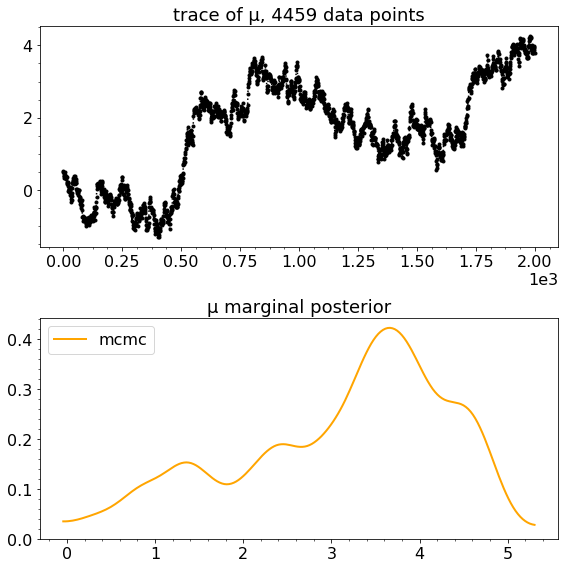

In [54]:
f, ax = pl.subplots(nrows=2, figsize=(8, 8))
ax[0].plot(np.arange(samples), trace2, marker='.',
           ls=':', color='k')
ax[0].set_title(f'trace of μ, {df_data.chl_l.size} data points')
ax[1].set_title('μ marginal posterior')
pm.plots.kdeplot(trace2, ax=ax[1], label='mcmc',
                 color='orange', lw=2, zorder=1)
ax[1].legend(loc='upper left')
ax[1].set_ylim(bottom=0)
f.tight_layout()
f.savefig('./figJar/Presentation/mcmc_2.svg')

<img src='./figJar/Presentation/mcmc_2.svg?modified=2'>

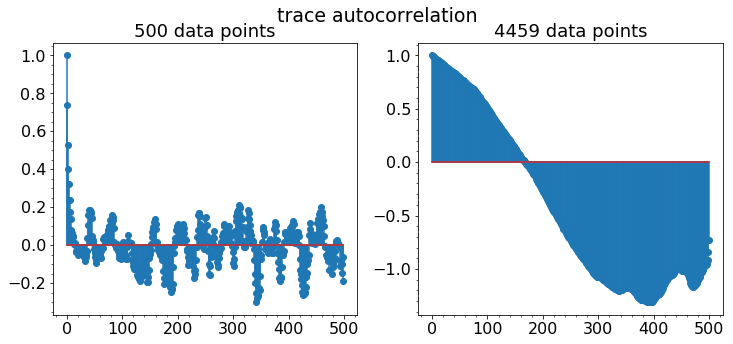

In [64]:
f, ax = pl.subplots(ncols=2, figsize=(12, 5))
ax[0].stem(pm.autocorr(trace1[1500:]))
ax[1].stem(pm.autocorr(trace2[1500:]))
ax[0].set_title(f'{df_data_s.chl_l.size} data points')
ax[1].set_title(f'{df_data.chl_l.size} data points')
f.suptitle('trace autocorrelation', fontsize=19)
f.savefig('./figJar/Presentation/grid8.svg')

<img src="./figJar/Presentation/grid8.svg"/>

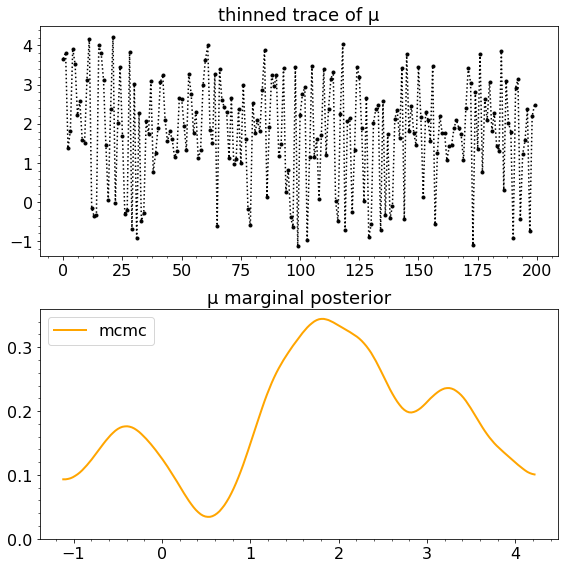

In [67]:
f, ax = pl.subplots(nrows=2, figsize=(8, 8))
thinned_trace = np.random.choice(trace2[100:], size=200, replace=False)
ax[0].plot(np.arange(200), thinned_trace, marker='.',
           ls=':', color='k')
ax[0].set_title('thinned trace of μ')
ax[1].set_title('μ marginal posterior')
pm.plots.kdeplot(thinned_trace, ax=ax[1], label='mcmc',
                 color='orange', lw=2, zorder=1)
ax[1].legend(loc='upper left')
ax[1].set_ylim(bottom=0)
f.tight_layout()
f.savefig('./figJar/Presentation/grid9.svg')

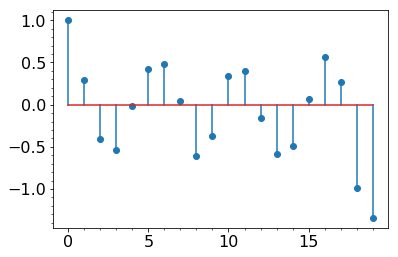

In [68]:
f, ax = pl.subplots()
ax.stem(pm.autocorr(thinned_trace[:20]));
f.savefig('./figJar/Presentation/stem2.svg', dpi=300, format='svg');

What's going on?

Highly autocorrelated trace: <br>
$\rightarrow$ inadequate parameter space exploration<br>
$\rightarrow$ poor convergence...

<table><tr>
    <td><img src='./figJar/Presentation/stem1.svg'></td>
    <td><img src='./figJar/Presentation/stem2.svg'></td>
    </tr>
</table>

Metropolis MCMC<br>
    $\rightarrow$ easy to implement + memory efficient<br>
    $\rightarrow$ inefficient parameter space exploration<br>
    $\rightarrow$ better MCMC sampler?

* **Hamiltonian Monte Carlo (HMC)**
* Greatly improved convergence
* Well mixed traces are a signature and an easy diagnostic
* HMC does require a lot of tuning,
* Not practical for the inexperienced applied statistician or scientist

* No-U-Turn Sampler (NUTS), HMC that automates most tuning steps
* NUTS  scales well to complex problems with many parameters (1000's)
* Implemented in popular libraries

##### Probabilistic modeling for the beginner
* <font color='red'>Under the hood: Inferring chlorophyll distribution</font>
    * ~~Grid approximation: computing probability everywhere~~
    * ~~MCMC: how it works~~
    * <font color='red'>Probabilistic Programming with PyMC3: Industrial grade MCMC </font>

[Back to Contents](#TOP)
<a id='PyMC3'></a> 

### <u>Probabilistic Programming with PyMC3</u>

* relatively simple syntax
* easily used in conjuction with mainstream python scientific data structures<br>
    $\rightarrow$numpy arrays <br>
    $\rightarrow$pandas dataframes
* models of reasonable complexity span ~10-20 lines.

In [93]:
with pm.Model() as m1:
    μ_ = pm.Normal('μ', mu=1, sd=1)
    σ = pm.Uniform('σ', lower=0, upper=2)
    lkl = pm.Normal('likelihood', mu=μ_, sd=σ,
                    observed=df_data.chl_l.dropna())

In [122]:
graph_m1 = pm.model_to_graphviz(m1)
graph_m1.format = 'svg'
graph_m1.render('./figJar/Presentation/graph_m1');

<center>
<img src="./figJar/Presentation/graph_m1.svg"/>
</center>

In [95]:
with m1:
    trace_m1 = pm.sample(2000, tune=1000, chains=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [σ, μ]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:05<00:00, 2014.56draws/s]


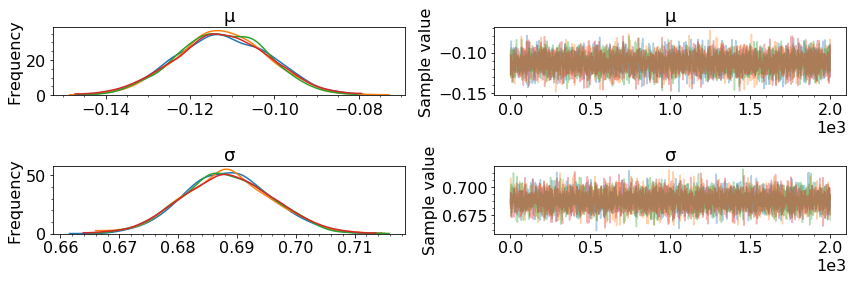

In [50]:
pm.traceplot(trace_m1);

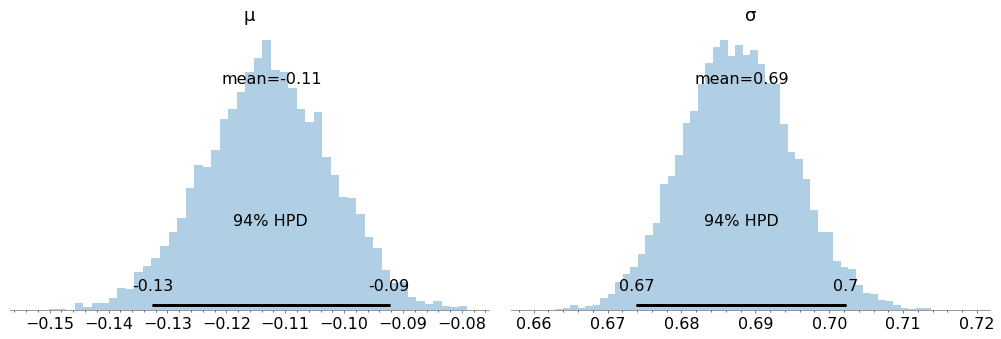

In [123]:
ar.plot_posterior(trace_m1, kind='hist', round_to=2);

[Back to Contents](#TOP)

<a id='Reg'></a>

#### <u><font color='purple'>Tutorial Overview:</font></u>
* Probabilistic modeling for the beginner<br>
    $\rightarrow$~~The basics~~<br>
    $\rightarrow$~~Starting easy: inferring chlorophyll~~<br>
    <font color='red'>$\rightarrow$Regression: adding a predictor to estimate chlorophyll</font>

[Back to Contents](#TOP)
<a id='DataPrep'></a>

## Regression: Adding a  predictor to estimate chlorophyll

* <font color=red>Data preparation</font>
* Writing a regression model in PyMC3
* Are my priors making sense?
* Model fitting
* Flavors of uncertainty

Linear regression takes the form

$$ y = \alpha + \beta x $$
where 
        $$\ \ \ \ \ y = log_{10}(chl)$$ and $$x = log_{10}\left(\frac{Gr}{MxBl}\right)$$


In [6]:
df_data.head().T

,0,1,2,3,4
rrs411_l,-2.48181,-2.69759,-2.57346,-2.74698,-2.85684
rrs443_l,-2.39369,-2.57914,-2.48391,-2.66945,-2.77425
rrs489_l,-2.32961,-2.44558,-2.39021,-2.56902,-2.6778
rrs510_l,-2.29265,-2.38804,-2.36096,-2.5593,-2.70144
rrs555_l,-2.26695,-2.36376,-2.34046,-2.59924,-2.80625
rrs670_l,-3.07818,-3.13471,-3.16042,-3.50443,-3.79611
mxBl_l,-2.29265,-2.38804,-2.36096,-2.5593,-2.6778
mxBlId,rrs510,rrs510,rrs510,rrs510,rrs489
MxBl-Gr,-0.0257098,-0.0242776,-0.0205022,0.0399411,0.128449
mxBlColor,#4eb3d3,#4eb3d3,#4eb3d3,#4eb3d3,#2b8cbe


In [100]:
df_data['Gr-MxBl'] = -1 * df_data['MxBl-Gr']

Regression coefficients easier to interpret with centered predictor:<br><br>
$$x_c = x - \bar{x}$$

In [101]:
df_data['Gr-MxBl_c'] = df_data['Gr-MxBl'] - df_data['Gr-MxBl'].mean()

In [102]:
df_data[['Gr-MxBl_c', 'chl_l']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4459 entries, 0 to 4458
Data columns (total 2 columns):
Gr-MxBl_c    4453 non-null float64
chl_l        4127 non-null float64
dtypes: float64(2)
memory usage: 104.5 KB


In [103]:
x_c = df_data.dropna()['Gr-MxBl_c'].values
y = df_data.dropna().chl_l.values

$$ y = \alpha + \beta x_c$$<br>
$\rightarrow \alpha=y$ when $x=\bar{x}$<br>
$\rightarrow \beta=\Delta y$ when $x$ increases by one unit

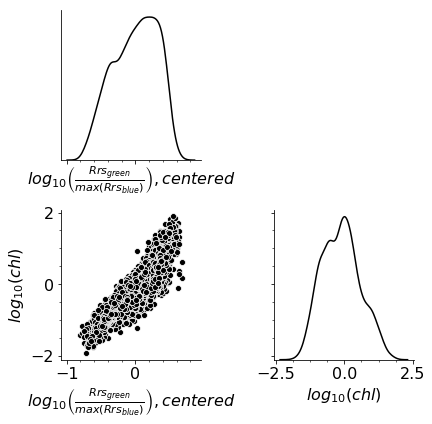

In [132]:
g3 = sb.PairGrid(df_data.loc[:, ['Gr-MxBl_c', 'chl_l']], height=3,
                         diag_sharey=False,)
g3.map_diag(sb.kdeplot, color='k')
g3.map_offdiag(sb.scatterplot, color='k');
make_lower_triangle(g3)
f = pl.gcf()
axs = f.get_axes()
xlabel = r'$log_{10}\left(\frac{Rrs_{green}}{max(Rrs_{blue})}\right), centered$'
ylabel = r'$log_{10}(chl)$'
axs[0].set_xlabel(xlabel)
axs[2].set_xlabel(xlabel)
axs[2].set_ylabel(ylabel)
axs[3].set_xlabel(ylabel)
f.tight_layout()
f.savefig('./figJar/Presentation/pairwise_1.png')

<center>
<img src='./figJar/Presentation/pairwise_1.png?modif=1' width="50%">
</center>

[Back to Contents](#TOP)
<a id='RegPyMC3'></a>

## Regression: Adding a  predictor to estimate chlorophyll

* ~~Data preparation~~
* <font color=red>Writing a regression model in PyMC3</font>
* Are my priors making sense?
* Model fitting
* Flavors of uncertainty

In [104]:
with pm.Model() as m_vague_prior:
    # priors
    σ = pm.Uniform('σ', lower=0, upper=2)
    α = pm.Normal('α', mu=0, sd=1)
    β = pm.Normal('β', mu=0, sd=1)
    # deterministic model
    μ = α + β * x_c
    # likelihood
    chl_i = pm.Normal('chl_i', mu=μ, sd=σ, observed=y)

In [120]:
graph = pm.model_to_graphviz(m_vague_prior)
graph.format='svg'
graph.render('./figJar/Presentation/m_vague_graph');

<center>
<img src="./figJar/Presentation/m_vague_graph.svg"/>
</center>

[Back to Contents](#TOP)
<a id='PriorCheck'></a>

## Regression: Adding a  predictor to estimate chlorophyll
* ~~Data preparation~~
* ~~Writing a regression model in PyMC3~~
* <font color=red>Are my priors making sense?</font>
* Model fitting 
* Flavors of uncertainty

In [136]:
vague_priors = pm.sample_prior_predictive(samples=500, model=m_vague_prior, vars=['α', 'β',])

In [107]:
x_dummy = np.linspace(-1.5, 1.5, num=50).reshape(-1, 1)

In [138]:
α_prior_vague = vague_priors['α'].reshape(1, -1)
β_prior_vague = vague_priors['β'].reshape(1, -1)
chl_l_prior_μ_vague = α_prior_vague + β_prior_vague * x_dummy

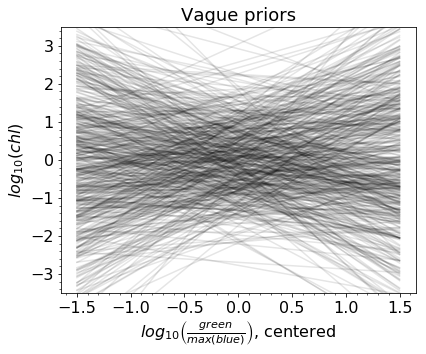

In [143]:
f, ax = pl.subplots( figsize=(6, 5))
ax.plot(x_dummy, chl_l_prior_μ_vague, color='k', alpha=0.1,);
ax.set_xlabel(r'$log_{10}\left(\frac{green}{max(blue)}\right)$, centered')
ax.set_ylabel('$log_{10}(chl)$')
ax.set_title('Vague priors')
ax.set_ylim(-3.5, 3.5)
f.tight_layout(pad=1)
f.savefig('./figJar/Presentation/prior_checks_1.png')

<center>
<img src='./figJar/Presentation/prior_checks_1.png?modified=3' width=65%>
</center

In [109]:
with pm.Model() as m_informative_prior:
    α = pm.Normal('α', mu=0, sd=0.2)
    β = pm.Normal('β', mu=0, sd=0.5)
    σ = pm.Uniform('σ', lower=0, upper=2)
    μ = α + β * x_c
    chl_i = pm.Normal('chl_i', mu=μ, sd=σ, observed=y)

In [140]:
prior_info = pm.sample_prior_predictive(model=m_informative_prior, vars=['α', 'β'])

In [141]:
α_prior_info = prior_info['α'].reshape(1, -1)
β_prior_info = prior_info['β'].reshape(1, -1)
chl_l_prior_info = α_prior_info + β_prior_info * x_dummy

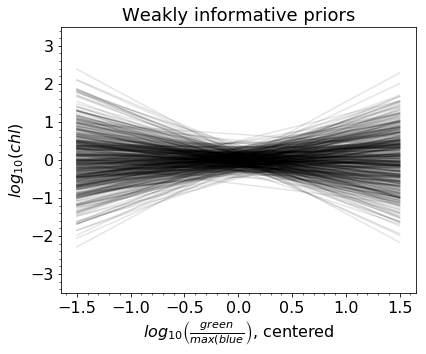

In [144]:
f, ax = pl.subplots( figsize=(6, 5))
ax.plot(x_dummy, chl_l_prior_info, color='k', alpha=0.1,);
ax.set_xlabel(r'$log_{10}\left(\frac{green}{max(blue}\right)$, centered')
ax.set_ylabel('$log_{10}(chl)$')
ax.set_title('Weakly informative priors')
ax.set_ylim(-3.5, 3.5)
f.tight_layout(pad=1)
f.savefig('./figJar/Presentation/prior_checks_2.png')

<center>
<img src='./figJar/Presentation/prior_checks_2.png?modif=2' width="65%" />
</center>

<table>
    <tr>
        <td>
            <img src='./figJar/Presentation/prior_checks_1.png?modif=1' />
        </td>
        <td>
            <img src='./figJar/Presentation/prior_checks_2.png?modif=2' />
        </td>
    </tr>
</table>


[Back to Contents](#TOP)
<a id='Mining'></a>

## Regression: Adding a  predictor to estimate chlorophyll
* ~~Data preparatrion~~
* ~~Writing a regression model in PyMC3~~
* ~~Are my priors making sense?~~
* <font color=red>Model fitting</font>
* Flavors of uncertainty

In [111]:
with m_vague_prior:
    trace_vague = pm.sample(2000, tune=1000, chains=4)

with m_informative_prior:
    trace_inf = pm.sample(2000, tune=1000, chains=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [β, α, σ]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:06<00:00, 2109.40draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [σ, β, α]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:06<00:00, 1841.36draws/s]


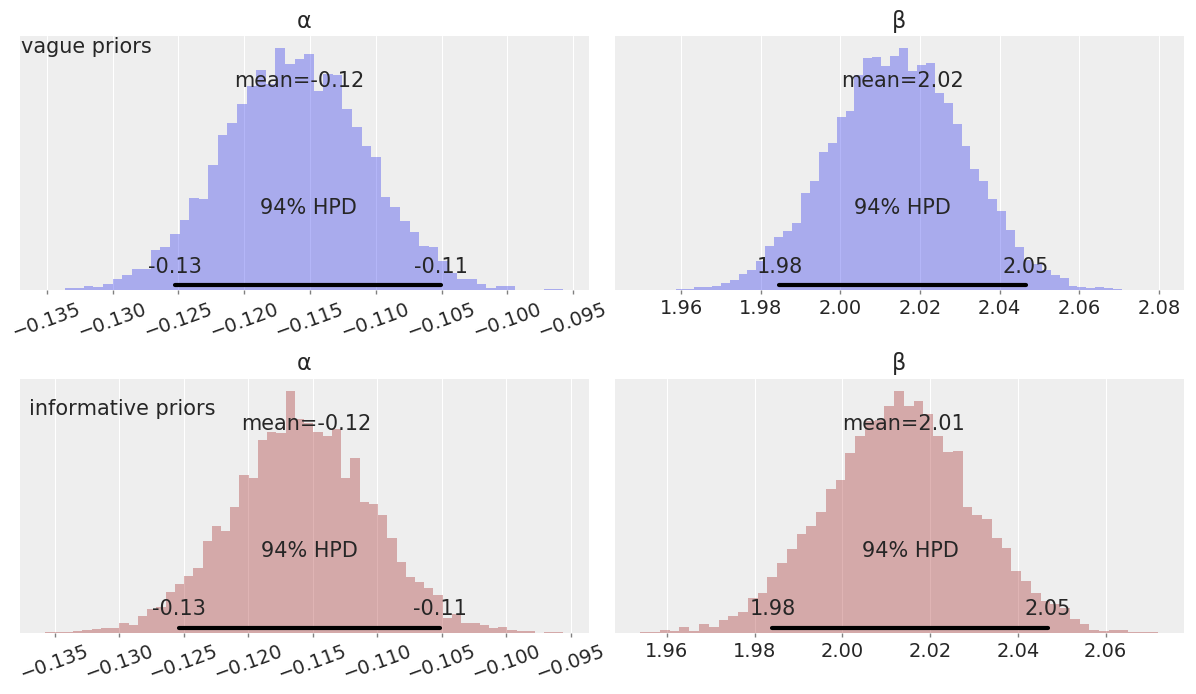

In [87]:
f, axs = pl.subplots(ncols=2, nrows=2, figsize=(12, 7))
ar.plot_posterior(trace_vague, var_names=['α', 'β'], round_to=2, ax=axs[0,:], kind='hist');
ar.plot_posterior(trace_inf, var_names=['α', 'β'], round_to=2, ax=axs[1, :], kind='hist',
                                        color='brown');
axs[0,0].tick_params(rotation=20)
axs[0,0].text(-0.137, 430, 'vague priors',
              fontdict={'fontsize': 15})
axs[1,0].tick_params(rotation=20)
axs[1,0].text(-0.137, 430, 'informative priors',
              fontdict={'fontsize': 15})
f.tight_layout()
f.savefig('./figJar/Presentation/reg_posteriors.svg')

<center>
<img src='./figJar/Presentation/reg_posteriors.svg'/>
</center>

[Back to Contents](#TOP)
<a id='UNC'></a>

## Regression: Adding a  predictor to estimate chlorophyll
* ~~Data preparation~~
* ~~Writing a regression model in PyMC3~~
* ~~Are my priors making sense?~~
* ~~Data review and model fitting~~
* <font color=red>Flavors of uncertainty</font>

Two types of uncertainties:
1. model uncertainty
2. prediction uncertainty

In [113]:
α_posterior = trace_inf.get_values('α').reshape(1, -1)
β_posterior = trace_inf.get_values('β').reshape(1, -1)
σ_posterior = trace_inf.get_values('σ').reshape(1, -1)

1. model uncertainty: uncertainty around the model mean

In [114]:
μ_posterior = α_posterior + β_posterior * x_dummy

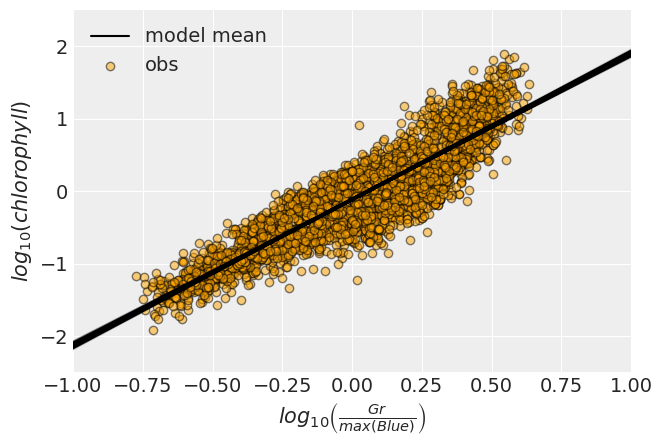

In [139]:
pl.plot(x_dummy, μ_posterior[:, ::16], color='k', alpha=0.1);
pl.plot(x_dummy, μ_posterior[:, 1], color='k', label='model mean')

pl.scatter(x_c, y, color='orange', edgecolor='k', alpha=0.5, label='obs'); pl.legend();
pl.ylim(-2.5, 2.5); pl.xlim(-1, 1);
pl.xlabel(r'$log_{10}\left(\frac{Gr}{max(Blue)}\right)$')
pl.ylabel(r'$log_{10}(chlorophyll)$')
f = pl.gcf()
f.savefig('./figJar/Presentation/mu_posterior.svg')

<center>
    <img src='./figJar/Presentation/mu_posterior.svg/'>
</center>     

2. prediction uncertainty: posterior predictive checks

In [115]:
ppc = norm.rvs(loc=μ_posterior, scale=σ_posterior);
ci_94_perc = pm.hpd(ppc.T, alpha=0.06);

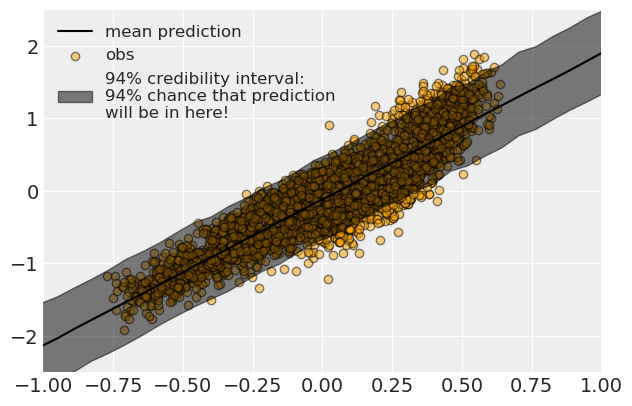

In [147]:
pl.scatter(x_c, y, color='orange', edgecolor='k', alpha=0.5, label='obs'); pl.legend();
pl.plot(x_dummy, ppc.mean(axis=1), color='k', label='mean prediction');
pl.fill_between(x_dummy.flatten(), ci_94_perc[:, 0], ci_94_perc[:, 1], alpha=0.5, color='k',
               label='94% credibility interval:\n94% chance that prediction\nwill be in here!');
pl.xlim(-1, 1); pl.ylim(-2.5, 2.5)
pl.legend(fontsize=12, loc='upper left')
f = pl.gcf()
f.savefig('./figJar/Presentation/ppc.svg')

<center>
    <img src='./figJar/Presentation/ppc.svg/' width="70%"/>
</center> 

[Back to Contents](#TOP)
<a id="Conclusion"></a>

### In Conclusion Probabilistic Programming provides:
* Transparent modeling:
    * Explicit assumptions
    * Easy to debate/criticize
    * Easy to communicate/reproduce/improve upon
* Posterior distribution much richer construct than point estimates
* Principled estimation of model and prediction uncertainty
* Accessibility
    * Constantly improving algorithms
    * Easy-to-use software
    * Flexible framework, largely problem-agnostic

<table><tr>
    <td><img src='./figJar/Presentation/krusche_diagrams_hs_reg.png?modif=2'/></td>
    <td><img src='./figJar/Presentation/krusche_diagrams_BNN.png?modif=1'/></td>
    </tr>
    </table>

[Back to Contents](#TOP)
<a id="Next"></a>

## To be continued...


<center>
<img src="./figJar/Presentation/bayes.jpg" width=60%>
</center>